# Project 1

Max Schrader

AEM 591

#### Resources

https://towardsdatascience.com/on-simulating-non-linear-dynamic-systems-with-python-or-how-to-gain-insights-without-using-ml-353eebf8dcc3

## Install the Required Packages

In [1]:
# !pip install pint
# !pip install numpy
# !pip install plotly
# !pip install prettytable

In [2]:
import os
from dataclasses import dataclass
import math
from typing import Union

import pint
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.signal import StateSpace, lsim
from prettytable import PrettyTable
import plotly.graph_objects as go
from plotly.tools import make_subplots
# import control

## Helper Functions

In [3]:
# ureg = pint.UnitRegistry()

In [4]:
def pretty_print(array: np.array, headers: list) -> None:
    x = PrettyTable()
    x.field_names = headers
    if len(headers) > 1 and len(array.shape) < 2:
        x.add_row(list(map(lambda x: round(x, 3), array)))
    else:
        for row in array:
#             if len(array.shape) > 1:
            x.add_row(list(map(lambda x: round(x, 3), row)) if isinstance(row, (list, np.ndarray)) else [round(row, 3)])

#             x.add_row(round(row, 3))
    print(x)

### Constants

In [5]:
@dataclass
class Elevator:

    I_m = 700
    K = 100
    K_v = 100
    L = 0.4
    m = 500
    g = 9.81
    W = 300 * 9.81
    r_0 = 3
    delta_c = 0.05
    R_0 = 5
    delta_r = 5
    t_r = 3
    
    def r_t(self, x=None, *args, **kwargs) -> float:
        x = x or self.x
        return (self.delta_c * x / math.pi + self.r_0 ** 2) ** (1/2) 
    
    def R_t(self, t: float) -> float:
        return self.R_0 + self.delta_r * (1 - math.exp((-1 * t) / self.t_r))
    

### Given Equations

## Problem 1

Setup two functions to compute the state and outputs in Python using the state-space system
representation above

In [38]:
# g = lambda x:  
class NonLinearElevator(Elevator):
    
    def __init__(self, x: float, doublet_d_t: float=None, doublet_c: float=None):
    
        self.doublet_c = doublet_c 
        self.doublet_d_t = doublet_d_t
        self.x = x
    
#     def f(self, ) -> object:
        
    # return inner function because scipy odeint doesn't like OOP 
    def _f(self, t: float, x_t: np.array) -> np.array:
        x_dot = np.zeros(4)
    
        # Time Variant Fns
        v_t = self.doublet(t)

        r_t = x_t[-1]
#         print(t, self.R_t(t), v_t, r_t)     
        x_dot[0] = x_t[1]

        x_dot[1] = (1 / (self.m * r_t - (self.I_m / r_t))) * \
                    (
                        (self.W * r_t - self.m * self.g * r_t + self.K * x_t[2]) \
                          - (self.I_m * self.delta_c * x_t[1]**2) / \
                            (2 * math.pi * r_t ** 3)
                    )

        x_dot[2] = v_t / self.L - (self.R_t(t) / self.L * x_t[2]) - ((self.K_v * x_t[1]) / (self.L * r_t))

        x_dot[3] = self.delta_c * x_t[1] / (2 * math.pi * r_t)
        return x_dot

#     return _f
    
    def out(self, ) -> object:
        def _out(x_t: np.array, t: float) -> np.array:
            out_dot = np.zeros(2)
            out_dot[0] = x_t[0]
            out_dot[1] = x_t[1]
            return out_dot
        return _out
    
    def doublet(self, t: float) -> float:
        return {
            0: 0,
            1: self.doublet_c,
            2: -1 * self.doublet_c,
            3: 0,
        }[min(t // (self.doublet_d_t / 2), 3)]

## Problem 2

ompute the linearized state-space system about three equilibrium/trim points at 𝑥 = 0,
15, and 30 m for a steady-state value of 𝑅 = 𝑅0 +𝛿𝑅, i.e. 𝑅(𝑡) as 𝑡 → ∞. Analyze the
controllability, observability, and stability in Python for the linearized system.

https://www.wolframalpha.com/input/?i2d=true&i=partial+derivative+of+%5C%2840%29Divide%5B1%2Cm*r+-+Divide%5BI%2Cr%5D%5D%5C%2841%29%5C%2840%29W*r+-+m*g*r+%2B+K*j+-+Divide%5BI+*+%CE%B4*Power%5Bx%2C2%5D%2C2+*+%CF%80*Power%5Br%2C3%5D%5D%5C%2841%29+with+respect+to+r

In [39]:
class LinearElevator(NonLinearElevator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self.x = x * ureg.meter
        
    def R_t(self, *args, **kwargs) -> float:
        return self.R_0 + self.delta_r
    
    """ Doing the linearized points as @property is not computationaly 
        efficient but makes the code most readable for me """
    @property
    def x_dot_bar(self, ) -> float:
        return 0
    
    @property
    def v_bar(self, ) -> float:
        return ((self.m * self.g - self.W) * (self.R_0 + self.delta_r)) / self.K * self.r_bar
    
    @property
    def i_bar(self, ) -> float:
        return self.v_bar / (self.R_0 + self.delta_r)
    
    @property
    def r_bar(self, ) -> float:
        return self.r_t()
    
    def df1_dx(self, *args, **kwargs) -> float:
        return np.array(
        [
            0, 
            1, 
            0, 
            0
        ])
    
    def df2_dx(self, ) -> np.array:
        return np.array(
            [
                0, 
                0, # (self.I_m * self.delta_c * x_t[1]) / (math.pi * self.m * r_t **4 + x_t[2] * math.pi * r_t ** 2) commented out because x_bar = 0
                (self.K * self.r_bar) / (self.m * self.r_bar**2 - self.I_m),
#                 ((2 * self.I_m * math.pi * self.r_bar ** 4 * (self.g * self.m - self.W)) / (math.pi * self.r_bar ** 3 * (self.m * self.r_bar**2 - self.I_m) ** 2)).to('m/s^2/m').magnitude
                ((- 1 * self.g * self.m) + self.W) / (self.m * self.r_bar - self.I_m / self.r_bar) - \
                (self.m + self.I_m / self.r_bar ** 2) * (-1 * self.g * self.m * self.r_bar + self.i_bar * self.K + self.r_bar * self.W) / \
                ((self.m * self.r_bar - self.I_m / self.r_bar) ** 2)
            ]
        )
    
    def df3_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                -1 * ((self.K) / (self.L * self.r_bar)),
                -1 * (self.R_t() / self.L),
                0 # because x_bar = 0
            ]
        )
    
    def df4_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                self.delta_c / (2 * math.pi * self.r_bar),
                0,
                0
            ]
        )
    
    @property
    def A(self, ) -> np.array:
        return np.asarray(
            [
                self.df1_dx(),
                self.df2_dx(),
                self.df3_dx(),
                self.df4_dx()
            ]
        )
    
    @property
    def B(self, ) -> np.array:
        return np.asarray(
            [[
                0,
                0,
                1 / self.L,
                0
            ]]
        )
    
    @property
    def C(self, ) -> np.array:
        return np.asarray(
            [
                [1, 0, 0, 0],
                [0, 1, 0, 0]
            ]
        )
    
    @property
    def D(self, ) -> np.array:
        return np.asarray(
            [[0, 0,]]
        )

### Checking the Units

### State Space at $x = 0$

In [40]:
elevator = LinearElevator(x=0)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+---------+-------+--------+
|  x  |  x_dot  |   i   |   r    |
+-----+---------+-------+--------+
| 0.0 |   1.0   |  0.0  |  0.0   |
| 0.0 |   0.0   | 0.079 | -1.549 |
| 0.0 | -83.333 | -25.0 |  0.0   |
| 0.0 |  0.003  |  0.0  |  0.0   |
+-----+---------+-------+--------+


In [41]:
pretty_print(elevator.B[0], ['v'])

+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


In [42]:
elevator.v_bar

588.5999999999999

#### Finding the stability

In [43]:
np.linalg.eigvals(elevator.A)

array([ 0.00000000e+00, -2.47340139e+01, -2.49329842e-01, -1.66562292e-02])

In [44]:
np.linalg.matrix_rank(elevator.A)

3

## Problem 3

Simulate the nonlinear system with doublet commands on $\dot{v}$, both up and down, for initial conditions close and far from the linearized states, but including $t$. Use input values which keep the elevator velocity reasonable

In [123]:
x = 30

doublet_magnitude = LinearElevator(x).v_bar * 4
doublet_dt = 0.2
t = np.linspace(0, doublet_dt / 2 * 3, 1000)

elevator = NonLinearElevator(x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

# compose the initial conditions
x0 = np.array([x, 0, LinearElevator(x).i_bar, LinearElevator(x).r_bar])

print("Doublet C", doublet_magnitude)
print("Doublet dt", doublet_dt)

print("X0 = ")
pretty_print(x0, headers=['x', 'x_dot', 'i', 'r'])

Doublet C 2416.045367861003
Doublet dt 0.2
X0 = 
+------+-------+--------+-------+
|  x   | x_dot |   i    |   r   |
+------+-------+--------+-------+
| 30.0 |  0.0  | 60.401 | 3.079 |
+------+-------+--------+-------+


In [126]:
# s = solve_ivp(elevator.f(), y0=x0, t_span=(t[0], t[-1]),)
s = solve_ivp(lambda x, y: elevator._f(x, y), y0=x0, t_span=(t[0], t[-1]), max_step=0.01)
# s = odeint(elevator.f(), y0=x0, t=t, tfirst=True)

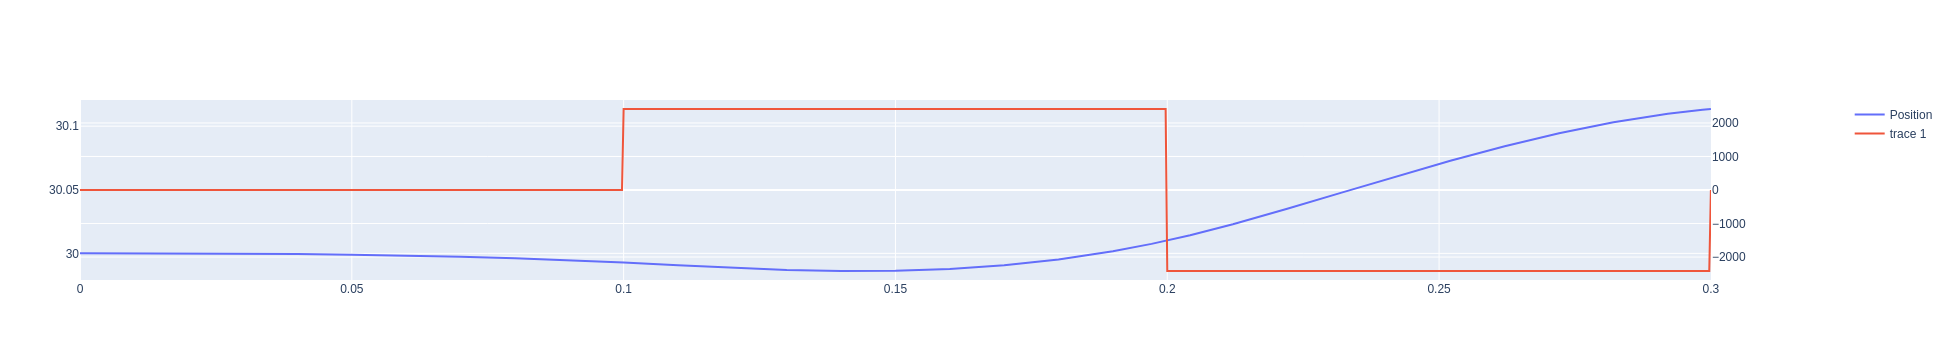

In [127]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# len(s)
fig.add_trace(go.Scatter(x=s.t, y=s.y[0], name="Position"))
fig.add_trace(go.Scatter(x=t, y=[elevator.doublet(_t) for _t in t]), secondary_y=True)
# isinstance(elevator.doublet_c, ureg.Quantity)

## Problem 4

Simulate the linearized system with doublet commands on $dot{v}$, both up and down, for initial conditions close to the linearized states. Use input values which keep the elevator velocity reasonable

### Position $x = 0$

In [116]:
x = 30

doublet_magnitude = LinearElevator(x).v_bar * 4
doublet_dt = 0.2
t = np.linspace(0, doublet_dt / 2 * 3, 1000)

elevator = LinearElevator(x=x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

U = np.asarray(list(elevator.doublet(_t) for _t in t))

elevator_ss = StateSpace(elevator.A, elevator.B.T, elevator.C, elevator.D.T)

In [117]:
_, y, s = lsim(elevator_ss, U, t, X0=np.array([elevator.x, 0, elevator.i_bar, elevator.r_bar]))

In [118]:
y

array([[ 3.00000000e+01,  0.00000000e+00],
       [ 3.00000000e+01, -5.17703960e-06],
       [ 3.00000000e+01, -2.06564950e-05],
       ...,
       [ 3.00010515e+01, -5.67413804e-01],
       [ 3.00008802e+01, -5.73445572e-01],
       [ 3.00007071e+01, -5.79476706e-01]])

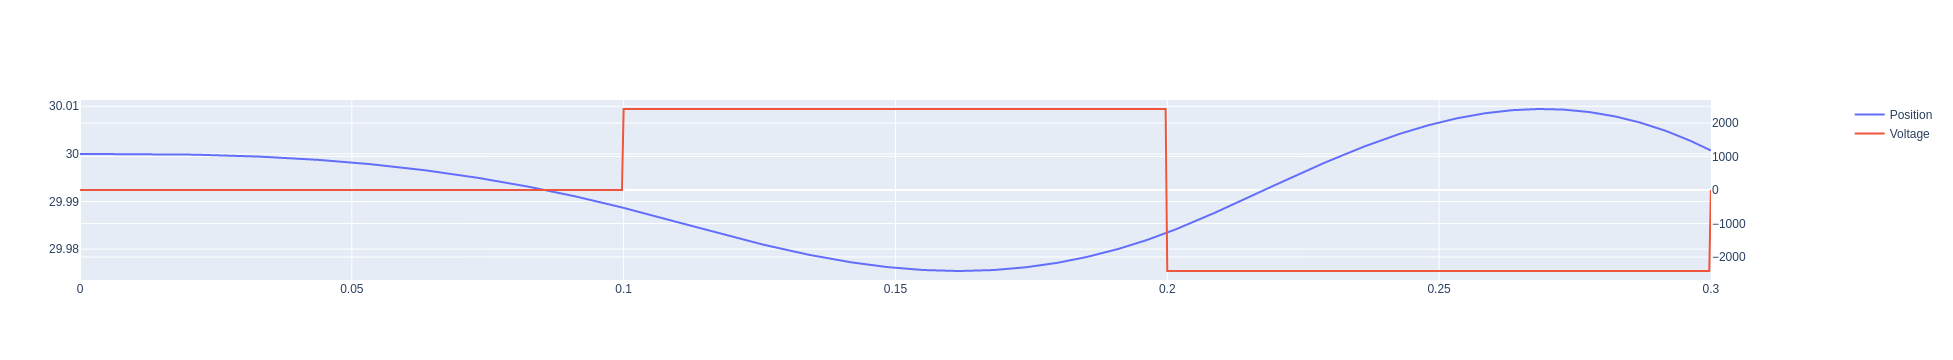

In [119]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# len(s)
fig.add_trace(go.Scatter(x=t, y=[_y[0] for _y in y], name="Position"))
fig.add_trace(go.Scatter(x=t, y=U, name="Voltage"), secondary_y=True,)
# isinstance(elevator.doublet_c, ureg.Quantity)
# fig.update_layout(yaxis=dict(range=[0, 20]))

In [120]:
def ode_linear(t, x_t, elevator_l, print_output=False):
#     print(x_t)
#     elevator_l.x = x_t[0]
    
    x_t = np.array([x_t[0] - elevator_l.x, x_t[1], x_t[2] - elevator_l.i_bar, x_t[3] - elevator_l.r_bar])
    
    if print_output:
        print(t, x_t, np.asarray([elevator_l.doublet(t) - elevator_l.v_bar]))
    
    return np.matmul(elevator_l.A, x_t) + np.matmul(elevator_l.B.T, np.asarray([elevator_l.doublet(t) - elevator_l.v_bar]))

In [121]:
# s = solve_ivp(ode_linear, y0=np.array([0, 0, elevator.i_bar.magnitude, elevator.r_bar.magnitude]), t_span=(t[0], t[-1]),)

s = odeint(ode_linear, y0=np.array([elevator.x, 0, elevator.i_bar, elevator.r_bar]), t=t, tfirst=True, args=(elevator, False))


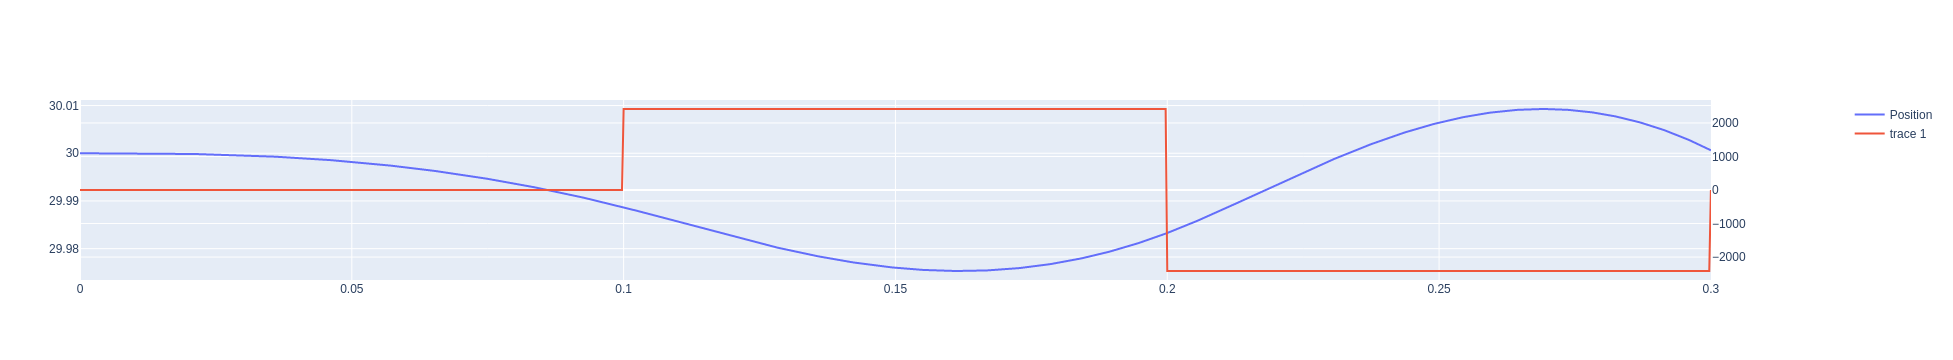

In [122]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# len(s)
fig.add_trace(go.Scatter(x=t, y=[t_[0] for t_ in s], name="Position"))
fig.add_trace(go.Scatter(x=t, y=[elevator.doublet(_t) for _t in t]), secondary_y=True)
# isinstance(elevator.doublet_c, ureg.Quantity)

## Problem 5

Write a few paragraphs summarizing the results of these simulations and any analysis. Make sure to compare the linear simulations to the nonlinear.